In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os
from pathlib import Path

In [2]:
sys.path.append('../src')
from physics.RICH_simulator import RICHSimulator
from physics import constants
from utils import visualisations, metrics

In [3]:
data_path = Path('../data/processed/rich_images.npz')

# Load the dataset
data = np.load(data_path)
images = data['images']

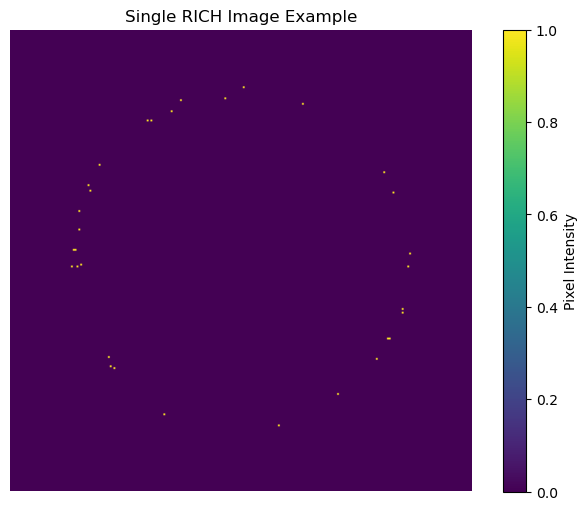

In [ ]:
# Display a grid of 9 images
#visualisations.display_image_grid(images, num_images=9)
plt.figure(figsize=(8, 6))
img = plt.imshow(images[5500], cmap='viridis')
plt.title('Single RICH Image Example')
plt.colorbar(img, label='Pixel Intensity')
plt.axis('off')
plt.show()